In [1]:
import numpy as np
import pandas as pd
import os
import datetime
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.dates as mdates
import scipy.stats as stats
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/nahwan25/Forecasting_ARIMA/refs/heads/main/Dataset/datasetforecasting.csv")
df.head()

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,2022-01-03,"182,01","177,83","182,88","177,71","104,70M","2,50%"
1,2022-01-04,"179,70","182,63","182,94","179,12","99,31M","-1,27%"
2,2022-01-05,"174,92","179,61","180,17","174,64","94,54M","-2,66%"
3,2022-01-06,"172,00","172,70","175,30","171,64","96,90M","-1,67%"
4,2022-01-07,"172,17","172,89","174,14","171,03","86,71M","0,10%"


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Tanggal     713 non-null    object
 1   Terakhir    713 non-null    object
 2   Pembukaan   713 non-null    object
 3   Tertinggi   713 non-null    object
 4   Terendah    713 non-null    object
 5   Vol.        713 non-null    object
 6   Perubahan%  713 non-null    object
dtypes: object(7)
memory usage: 39.1+ KB


In [4]:
# Ubah koma menjadi titik (jika ada), hapus spasi, lalu konversi ke numerik
df[['Pembukaan']] = df[['Pembukaan']].replace(',', '.', regex=True).apply(lambda x: x.str.strip()).apply(pd.to_numeric, errors='coerce')

In [5]:
# Pilih hanya kolom Terakhir untuk forecasting
df_forecast = df[['Tanggal', 'Pembukaan']].copy()

In [6]:
df_forecast.isnull().sum()

,0
Tanggal,0
Pembukaan,0


In [7]:
df_forecast.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pembukaan,713.0,174.674474,25.868117,126.01,154.64,172.33,189.33,236.48


<Axes: xlabel='Pembukaan'>

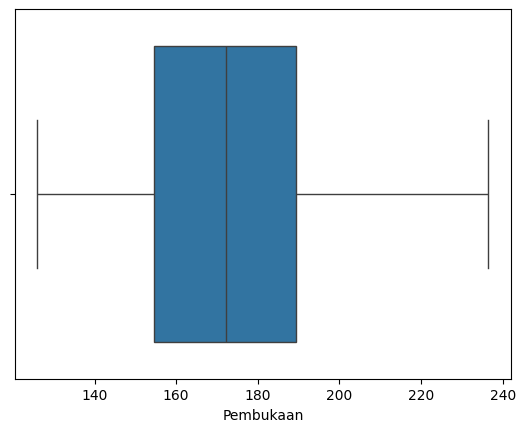

In [8]:
sns.boxplot(x=df_forecast["Pembukaan"])

1. **Tren Kenaikan Harga**  **teks tebal**
   - Dari tahun 2022 hingga 2024, terlihat adanya kenaikan harga secara bertahap, terutama setelah pertengahan tahun.  

2. **Volatilitas Harga**  
   - Tahun 2024 menunjukkan rentang harga yang lebih lebar dibandingkan tahun-tahun sebelumnya, menandakan fluktuasi yang lebih tinggi.  
   - Sebaliknya, tahun 2022 memiliki distribusi harga yang lebih stabil dengan variabilitas yang lebih kecil.  

3. **Adanya Outlier**  
   - Pada tahun 2023 dan 2024, ditemukan banyak outlier terutama di bulan Juli hingga September.  
   - Hal ini mengindikasikan adanya faktor eksternal yang menyebabkan lonjakan atau penurunan harga yang tidak biasa.  

4. **Potensi Faktor Musiman**  
   - Distribusi harga menunjukkan adanya pola yang berulang setiap tahun, yang bisa disebabkan oleh faktor musiman atau kebijakan tertentu.  

The Time period

How long is the period in days?

In [9]:
df_forecast["Tanggal"] = pd.to_datetime(df_forecast.Tanggal, cache=True)

df_forecast.Tanggal.max() - df_forecast.Tanggal.min()

Timedelta('1033 days 00:00:00')

Jumlah dataset 713 data dana panjang periode 1033, bisa dilihat banyak hari yang tidak diisi atau dilompatin saja karena itu dilakukan pengisian hari yang hilang (resampling). Saya akan melakukan pengisiin denngan motode Moving Average (MA), interpolasi berbasis rata-rata bergerak.

In [10]:
# Ubah kolom tanggal menjadi format datetime dan jadikan index
df_forecast['Tanggal'] = pd.to_datetime(df_forecast['Tanggal'])
df_forecast.set_index('Tanggal', inplace=True)

# Tambahkan tanggal yang hilang
df_forecast = df_forecast.asfreq('D')
print(df_forecast)

            Pembukaan
Tanggal              
2022-01-03     177.83
2022-01-04     182.63
2022-01-05     179.61
2022-01-06     172.70
2022-01-07     172.89
...               ...
2024-10-28     233.32
2024-10-29     233.10
2024-10-30     232.61
2024-10-31     229.34
2024-11-01     220.96

[1034 rows x 1 columns]


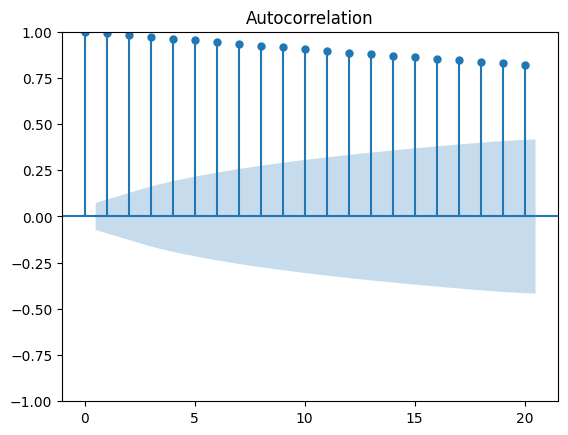

In [11]:
plot_acf(df_forecast['Pembukaan'].dropna(), lags=20)
plt.show()

In [12]:
#Mengis data hilang denagn MA
df_forecast['Pembukaan'] = df_forecast['Pembukaan'].fillna(df_forecast['Pembukaan'].rolling(window=3, min_periods=1).mean())

In [13]:
df_forecast.reset_index(inplace=True)

In [14]:
df_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1034 entries, 0 to 1033
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Tanggal    1034 non-null   datetime64[ns]
 1   Pembukaan  1012 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 16.3 KB


In [15]:
print("Datafile starts with timepoint {}".format(df_forecast.Tanggal.min()))
print("Datafile ends with timepoint {}".format(df_forecast.Tanggal.max()))

Datafile starts with timepoint 2022-01-03 00:00:00
Datafile ends with timepoint 2024-11-01 00:00:00


In [16]:
#Mengis data hilang denagn MA
df_forecast['Pembukaan'] = df_forecast['Pembukaan'].fillna(df_forecast['Pembukaan'].rolling(window=3, min_periods=1).mean())

The invoice number

How many different invoice numbers do we have?

In [17]:
df_forecast.nunique()

,0
Tanggal,1034
Pembukaan,846


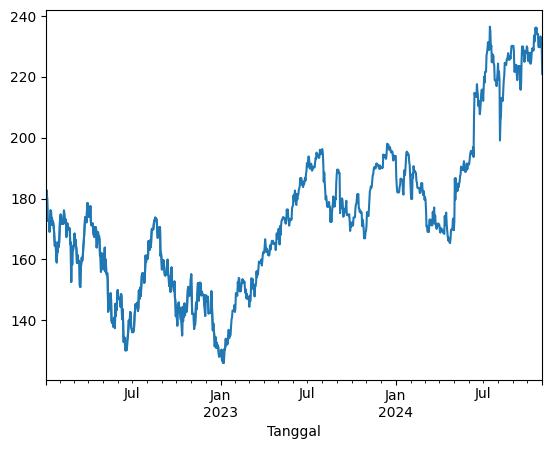

In [18]:
plot_features = df_forecast["Pembukaan"]
plot_features.index = df_forecast['Tanggal']
_ = plot_features.plot(subplots=True)

plot_features = df_forecast["Pembukaan"][:380]
plot_features.index = df_forecast['Tanggal'][:380]
_ = plot_features.plot(subplots=True)

In [19]:
df_forecast.isnull().sum()

,0
Tanggal,0
Pembukaan,0


<ipython-input-20-c962a47f4a5e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=Terakhir_counts.iloc[0:20].index,


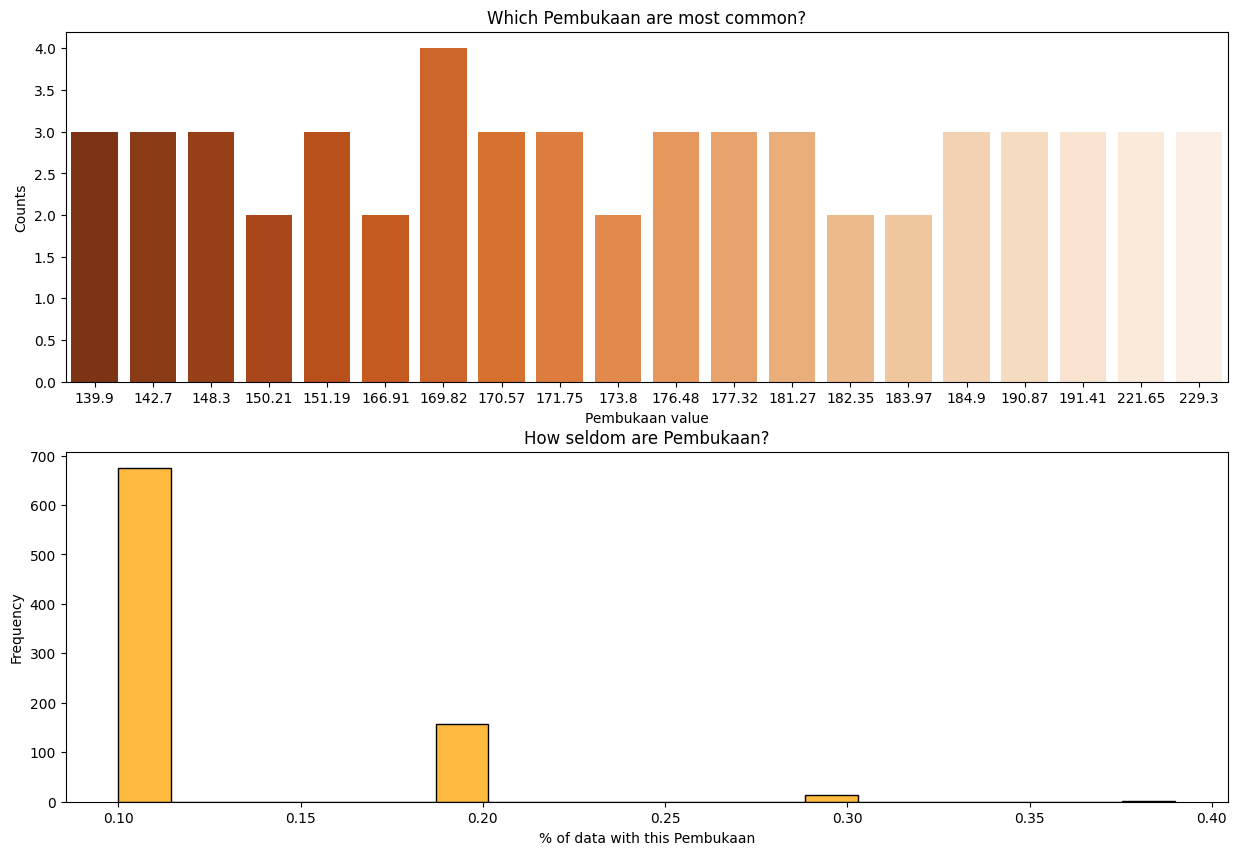

In [20]:
# Hitung jumlah kemunculan setiap stockcode
Terakhir_counts = df_forecast["Pembukaan"].value_counts().sort_values(ascending=False)

# Buat subplot dengan 2 baris, 1 kolom
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

# Plot barplot (20 stockcode teratas)
sns.barplot(x=Terakhir_counts.iloc[0:20].index,
            y=Terakhir_counts.iloc[0:20].values,
            ax=ax[0], palette="Oranges_r")

ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Pembukaan value")
ax[0].set_title("Which Pembukaan are most common?")

# Plot histogram distribusi stockcode
sns.histplot(np.round(Terakhir_counts/df_forecast.shape[0]*100,2),
             bins=20, ax=ax[1], color="Orange")

ax[1].set_title("How seldom are Pembukaan?")
ax[1].set_xlabel("% of data with this Pembukaan")
ax[1].set_ylabel("Frequency")
plt.show()

Boxplot per periode bulan disetiap tahun

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


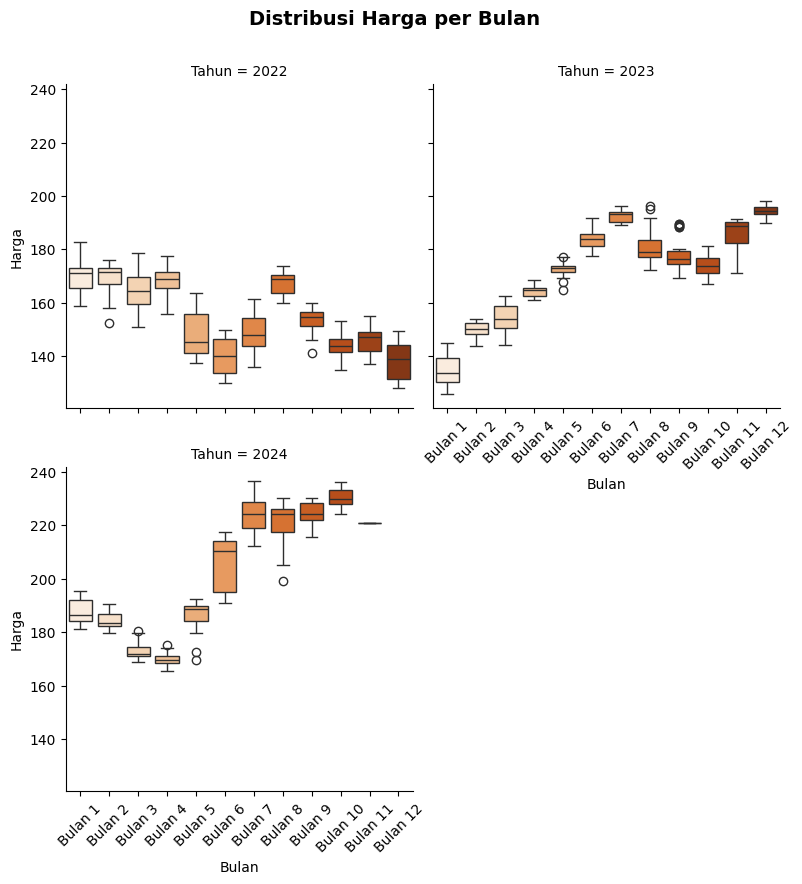

In [21]:
# Pastikan kolom tanggal dalam format datetime
df_forecast['Tanggal'] = pd.to_datetime(df_forecast['Tanggal'])
df_forecast['Bulan'] = df_forecast['Tanggal'].dt.month
df_forecast['Tahun'] = df_forecast['Tanggal'].dt.year

# Buat FacetGrid untuk memisahkan setiap tahun dalam plot terpisah
g = sns.FacetGrid(df_forecast, col="Tahun", col_wrap=2, height=4, sharey=True)

# Tambahkan boxplot ke setiap subplot
g.map_dataframe(sns.boxplot, x="Bulan", y="Pembukaan", palette="Oranges", order=range(1, 13))

# Tambahkan judul
g.fig.suptitle("Distribusi Harga per Bulan", fontsize=14, fontweight='bold', y=1.05)

# Sesuaikan label sumbu
g.set_axis_labels("Bulan", "Harga")
g.set_xticklabels([f"Bulan {i}" for i in range(1, 13)], rotation=45)

plt.show()

In [22]:
result = adfuller(df_forecast.Pembukaan.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.922716
p-value: 0.780400


In [23]:
print(df_forecast['Pembukaan'].min())  # Cek nilai terkecil

126.01


In [24]:
df_forecast

,Tanggal,Pembukaan,Bulan,Tahun
0,2022-01-03,177.83,1,2022
1,2022-01-04,182.63,1,2022
2,2022-01-05,179.61,1,2022
3,2022-01-06,172.70,1,2022
4,2022-01-07,172.89,1,2022
...,...,...,...,...
1029,2024-10-28,233.32,10,2024
1030,2024-10-29,233.10,10,2024
1031,2024-10-30,232.61,10,2024
1032,2024-10-31,229.34,10,2024


In [25]:
df_forecast.to_csv("datasetforecasting_cleaned.csv")  # Simpan file CSV

from google.colab import files
files.download("datasetforecasting_cleaned.csv")  # Download file

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

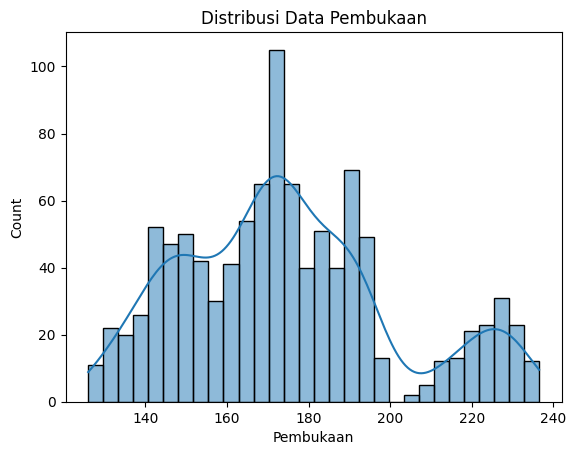

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df_forecast['Pembukaan'], bins=30, kde=True)
plt.title("Distribusi Data Pembukaan")
plt.show()

In [27]:
pt = PowerTransformer(method='yeo-johnson')
df_forecast['Pembukaan_log'] = pt.fit_transform(df_forecast[['Pembukaan']])

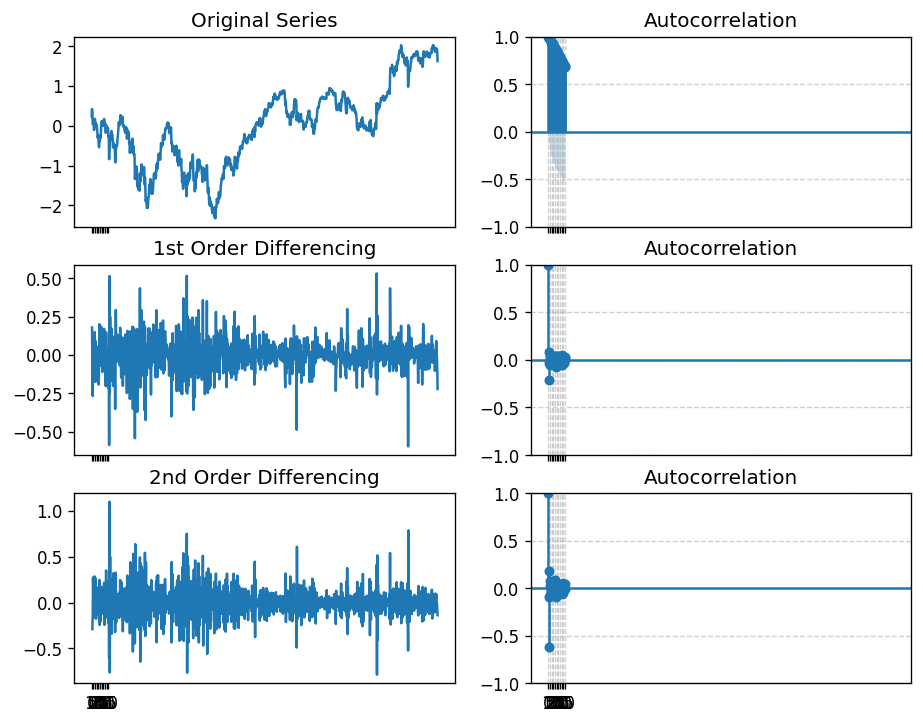

In [28]:
plt.rcParams.update({'figure.figsize': (9, 7), 'figure.dpi': 120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df_forecast.Pembukaan_log)
axes[0, 0].set_title('Original Series')
plot_acf(df_forecast.Pembukaan_log, ax=axes[0, 1], lags=50)

# 1st Differencing
axes[1, 0].plot(df_forecast.Pembukaan_log.diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_forecast.Pembukaan_log.diff().dropna(), ax=axes[1, 1], lags=50)

# 2nd Differencing
axes[2, 0].plot(df_forecast.Pembukaan_log.diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_forecast.Pembukaan_log.diff().diff().dropna(), ax=axes[2, 1], lags=50)

# Perbaikan tampilan
for ax in axes[:, 1]:  # Mengatur untuk semua plot autocorrelation
    ax.grid(True, linestyle='--', alpha=0.6)  # Menambahkan grid
    ax.set_xticks(range(0, 51, 5))  # Menyesuaikan sumbu x agar lebih rapi

plt.show()

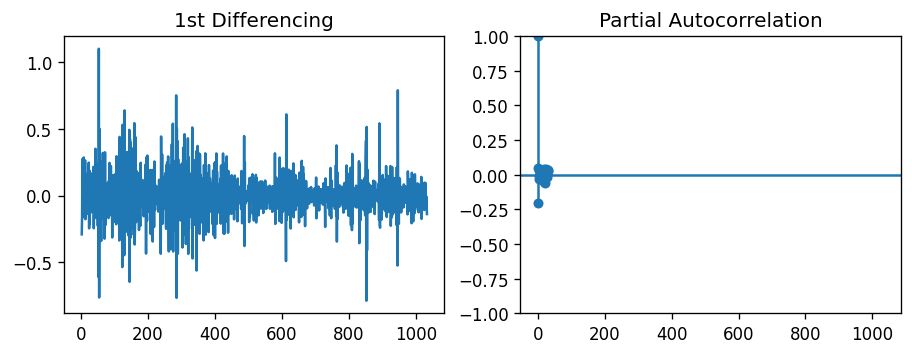

In [29]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_forecast.Pembukaan_log.diff().diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df_forecast.Pembukaan_log.diff().dropna(), ax=axes[1])

plt.show()

In [30]:
df_forecast.Pembukaan_log.head()

,Pembukaan_log
0,0.240281
1,0.419015
2,0.307422
3,0.040832
4,0.048381


In [31]:
# Simpan hasil AIC untuk tiap window
results = []

for w in range(1, 11):  # Window dari 1 sampai 10
    df_forecast['Pembukaan_filled'] = df_forecast['Pembukaan_log'].fillna(
        df_forecast['Pembukaan_log'].rolling(window=w, min_periods=1).mean()
    )

    # Latih model ARIMA(1,1,1)
    model = ARIMA(df_forecast['Pembukaan_filled'], order=(1,1,1)).fit()

    # Simpan window dan AIC
    results.append((w, model.aic))

# Cari window dengan AIC terkecil
best_window, best_aic = min(results, key=lambda x: x[1])

print(f"Window terbaik: {best_window}, AIC: {best_aic}")

Window terbaik: 1, AIC: -1628.110737654446


In [32]:
# Definisi model ARIMA
model = ARIMA(df_forecast.Pembukaan_log, order=(1,2,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:          Pembukaan_log   No. Observations:                 1034
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 810.865
Date:                Mon, 17 Feb 2025   AIC                          -1615.731
Time:                        04:06:27   BIC                          -1600.913
Sample:                             0   HQIC                         -1610.108
                               - 1034                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2065      0.024     -8.642      0.000      -0.253      -0.160
ma.L1         -0.9991      0.010   -103.798      0.000      -1.018      -0.980
sigma2         0.0121      0.000     36.686      0.0

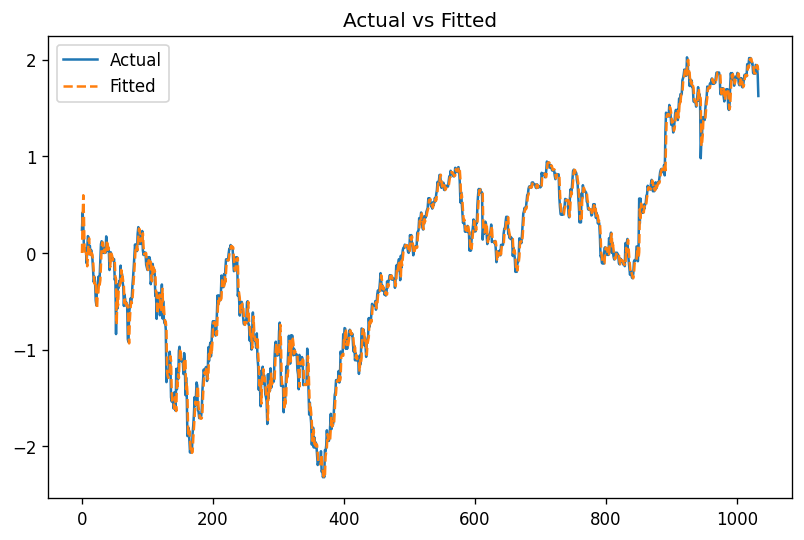

In [33]:
# Buat prediksi in-sample
predictions = model_fit.get_prediction(start=0, end=len(df_forecast.Pembukaan_log)-1, dynamic=False)
# Ambil mean forecast
pred_mean = predictions.predicted_mean
# Plot data asli dan prediksi
plt.figure(figsize=(8,5))
plt.plot(df_forecast.index, df_forecast.Pembukaan_log, label='Actual')
plt.plot(df_forecast.index, pred_mean, label='Fitted', linestyle='dashed')
plt.legend()
plt.title('Actual vs Fitted')
plt.show()

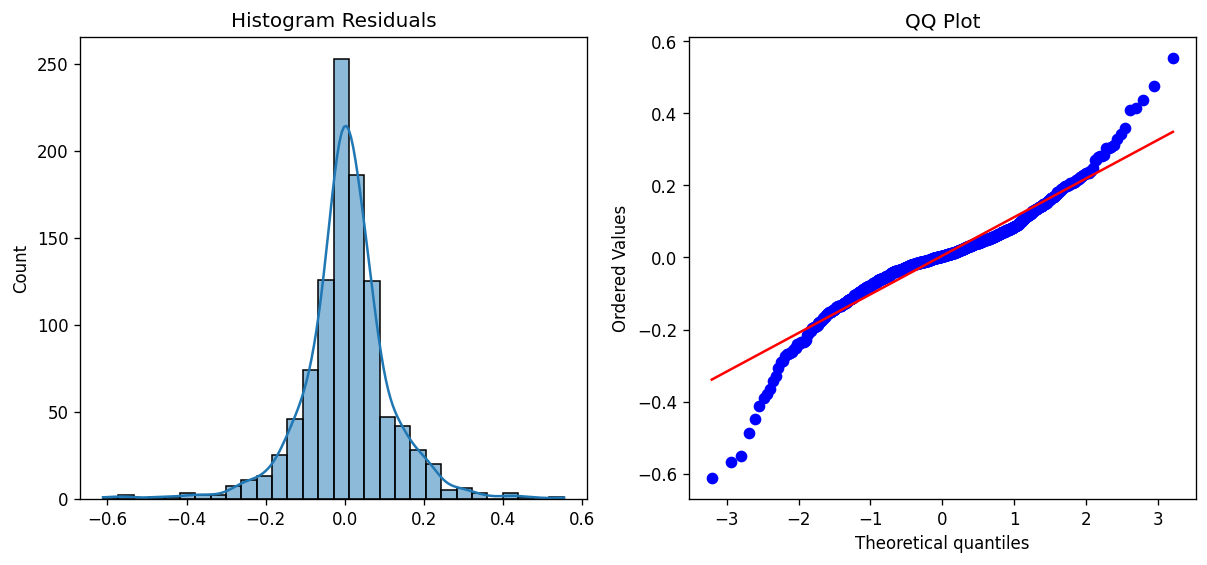

In [34]:
# Pastikan model sudah di-fit
fitted_model = model.fit()  # Pastikan model sudah di-fit
residuals = fitted_model.resid  # Ambil residual dari model yang sudah di-fit

# Plot distribusi residual
plt.figure(figsize=(12,5))

# Histogram Residuals
plt.subplot(1,2,1)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram Residuals')

# QQ Plot Residuals
plt.subplot(1,2,2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot')

plt.show()

Sarima

In [35]:
warnings.filterwarnings("ignore")  # Supaya output tidak penuh warning

# Tentukan nilai parameter musiman yang ingin dicoba
p, d, q = (1, 2, 1)  # Sesuai hasil tuning ARIMA sebelumnya
P_values = [0, 1, 2]  # Nilai P (AR musiman)
D_values = [0, 1]     # Nilai D (Differencing musiman)
Q_values = [0, 1, 2]  # Nilai Q (MA musiman)
s = 7  # Asumsikan data mingguan, ubah sesuai kebutuhan

# Semua kombinasi parameter musiman
param_seasonal = list(itertools.product(P_values, D_values, Q_values, [s]))

best_aic = float("inf")
best_param = None
best_model = None

# Coba semua kombinasi parameter
for param_s in param_seasonal:
    try:
        model = SARIMAX(df_forecast['Pembukaan_log'],
                        order=(p, d, q),
                        seasonal_order=param_s,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        result = model.fit()

        print(f"SARIMA{(p,d,q)}x{param_s} - AIC: {result.aic}")

        if result.aic < best_aic:
            best_aic = result.aic
            best_param = param_s
            best_model = result
    except:
        continue

print("\n Model terbaik:")
print(f"SARIMA{(p,d,q)}x{best_param} - AIC: {best_aic}")

SARIMA(1, 2, 1)x(0, 0, 0, 7) - AIC: -1616.1330609489787
SARIMA(1, 2, 1)x(0, 0, 1, 7) - AIC: -1606.322890253231
SARIMA(1, 2, 1)x(0, 0, 2, 7) - AIC: -1592.8704322263916
SARIMA(1, 2, 1)x(0, 1, 0, 7) - AIC: -929.285159454553
SARIMA(1, 2, 1)x(0, 1, 1, 7) - AIC: -1558.4454202294378
SARIMA(1, 2, 1)x(0, 1, 2, 7) - AIC: -1545.202208340352
SARIMA(1, 2, 1)x(1, 0, 0, 7) - AIC: -1607.442133803731
SARIMA(1, 2, 1)x(1, 0, 1, 7) - AIC: -1607.0605637545277
SARIMA(1, 2, 1)x(1, 0, 2, 7) - AIC: -1590.9246141786539
SARIMA(1, 2, 1)x(1, 1, 0, 7) - AIC: -1211.3947863419855
SARIMA(1, 2, 1)x(1, 1, 1, 7) - AIC: -1557.3502467577655
SARIMA(1, 2, 1)x(1, 1, 2, 7) - AIC: -1544.0943822287636
SARIMA(1, 2, 1)x(2, 0, 0, 7) - AIC: -1594.3211699399544
SARIMA(1, 2, 1)x(2, 0, 1, 7) - AIC: -1592.3613162508514
SARIMA(1, 2, 1)x(2, 0, 2, 7) - AIC: -1591.1806642130032
SARIMA(1, 2, 1)x(2, 1, 0, 7) - AIC: -1318.9434586990565
SARIMA(1, 2, 1)x(2, 1, 1, 7) - AIC: -1544.0923631573896
SARIMA(1, 2, 1)x(2, 1, 2, 7) - AIC: -1541.92582845044

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Definisi model SARIMA
model = SARIMAX(df_forecast['Pembukaan_log'],
                order=(1,2,1),          # ARIMA(1,2,1)
                seasonal_order=(0,0,0,7), # Sesuai hasil tuning (0,0,0,7)
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fitting model
model_fit = model.fit()

# Ringkasan hasil
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:          Pembukaan_log   No. Observations:                 1034
Model:               SARIMAX(1, 2, 1)   Log Likelihood                 811.067
Date:                Mon, 17 Feb 2025   AIC                          -1616.133
Time:                        04:07:16   BIC                          -1601.321
Sample:                             0   HQIC                         -1610.512
                               - 1034                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2101      0.024     -8.833      0.000      -0.257      -0.164
ma.L1         -0.9986      0.007   -141.128      0.000      -1.012      -0.985
sigma2         0.0121      0.000     38.163      0.0

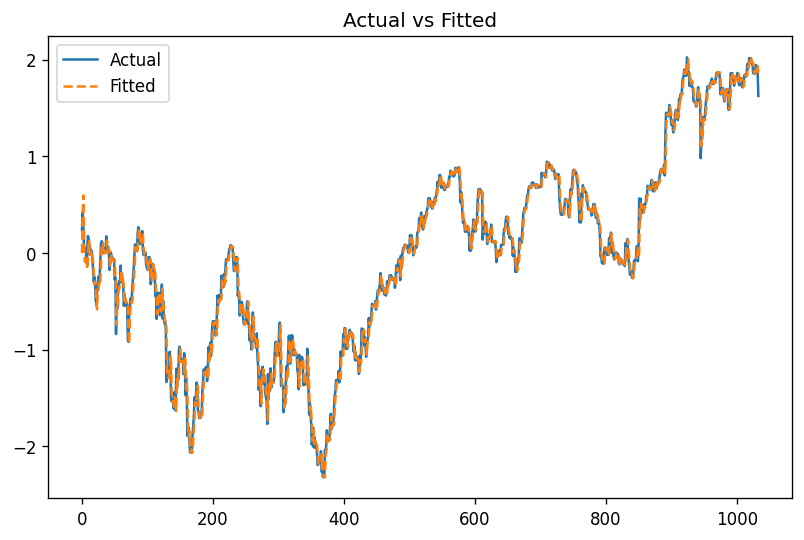

In [37]:
# Buat prediksi in-sample
predictions = model_fit.get_prediction(start=0, end=len(df_forecast.Pembukaan_log)-1, dynamic=False)
# Ambil mean forecast
pred_mean = predictions.predicted_mean
# Plot data asli dan prediksi
plt.figure(figsize=(8,5))
plt.plot(df_forecast.index, df_forecast.Pembukaan_log, label='Actual')
plt.plot(df_forecast.index, pred_mean, label='Fitted', linestyle='dashed')
plt.legend()
plt.title('Actual vs Fitted')
plt.show()

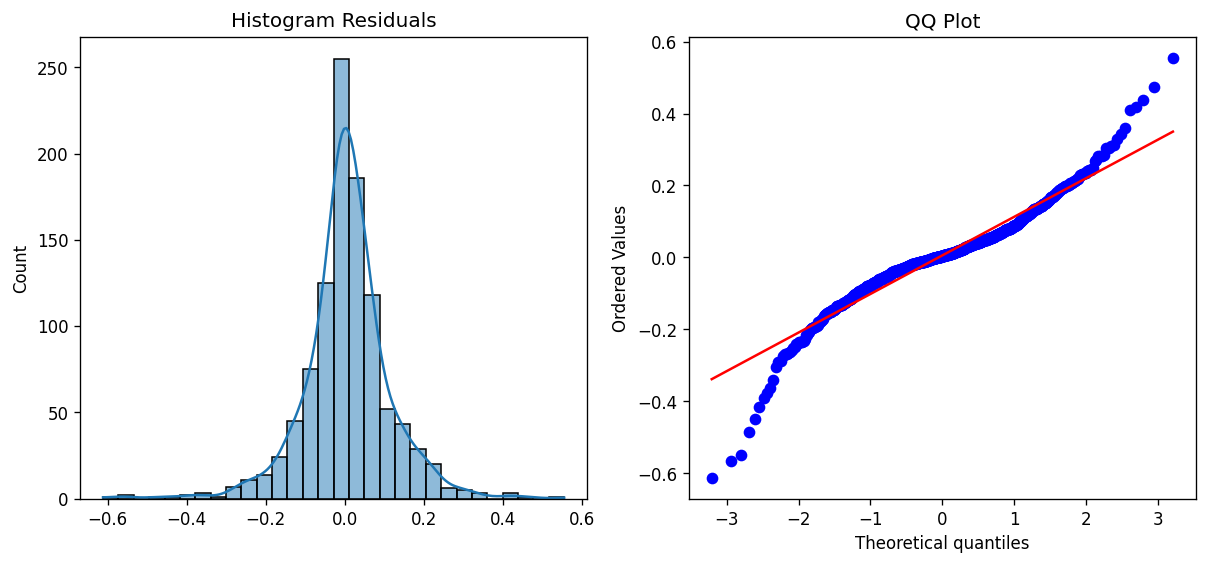

In [38]:
# Pastikan model sudah di-fit
fitted_model = model.fit()  # Pastikan model sudah di-fit
residuals = fitted_model.resid  # Ambil residual dari model yang sudah di-fit

# Plot distribusi residual
plt.figure(figsize=(12,5))

# Histogram Residuals
plt.subplot(1,2,1)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram Residuals')

# QQ Plot Residuals
plt.subplot(1,2,2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot')

plt.show()

Berdasarkan hasil evaluasi model ARIMA(1,2,1) dan SARIMAX(1,2,1), dapat disimpulkan bahwa:  

1. **Evaluasi Kinerja Model**  
   - **SARIMAX(1,2,1) memiliki nilai AIC (-1616.133) dan BIC (-1601.321) yang lebih rendah** dibandingkan ARIMA(1,2,1) (-1615.731 dan -1600.913), menunjukkan bahwa model ini memiliki kompleksitas yang lebih optimal.  
   - **Log Likelihood SARIMAX (811.067) sedikit lebih tinggi** dibandingkan ARIMA (810.865), yang menunjukkan bahwa model ini lebih baik dalam menangkap pola data.  
   - **Nilai Ljung-Box Q-test menunjukkan bahwa kedua model tidak memiliki autokorelasi yang signifikan**, sehingga keduanya valid untuk digunakan.  

2. **Karakteristik Model**  
   - **ARIMA(1,2,1) lebih sederhana** dan cocok untuk univariate time series tanpa faktor eksternal.  
   - **SARIMAX(1,2,1) lebih fleksibel** dan dapat digunakan untuk menangkap pengaruh faktor eksternal (exogenous variables) jika diperlukan di masa depan.  

3. **Rekomendasi Model Terbaik**  
   - Meskipun perbedaan performa antara kedua model tidak terlalu besar, **SARIMAX(1,2,1) sedikit lebih unggul** dalam hal evaluasi numerik.  
   - Jika tidak ada variabel tambahan yang memengaruhi data, **ARIMA(1,2,1) sudah cukup baik dan lebih sederhana**.  
   - **Jika di masa depan perlu menambahkan faktor eksternal (misalnya variabel makroekonomi, cuaca, atau promosi), SARIMAX lebih direkomendasikan.**  

Dengan pertimbangan di atas, **SARIMAX(1,2,1) dipilih sebagai model terbaik karena memiliki performa yang lebih baik dan fleksibilitas lebih tinggi untuk pengembangan lebih lanjut.**